In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torchvision.utils import make_grid
import torch.optim as optim
import time
from tqdm import tqdm
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Pre-process Data

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 specific
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


# Create and Train Autoencoder

In [ ]:
def train(model, trainloader, valloader, optimizer, criterion, num_epochs, l1_reg=None):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in tqdm(trainloader, total=len(trainloader)):
            inputs, _ = data
            inputs = inputs.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            if l1_reg is not None:
                l1_loss = l1_reg * torch.norm(model.bottleneck.weight, 1)
                loss += l1_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                inputs, _ = data
                inputs = inputs.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()

        train_loss /= len(trainloader)
        val_loss /= len(valloader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


In [ ]:
criterion = nn.MSELoss()
num_epochs = 50

In [ ]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(32 * 8 * 8, 2000)

        self.decoder = nn.Sequential(
            nn.Linear(2000, 32 * 8 * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
        )

    def extract_features(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        x = self.decoder[0](x)
        x = x.view(x.size(0), 32, 8, 8)
        x = self.decoder[1:](x)
        return x



In [ ]:
# Sparse Autoencoder
sparse_autoencoder = SparseAutoencoder().cuda()
optimizer_sparse = optim.Adam(sparse_autoencoder.parameters(), lr=0.0001)
train_losses_sparse, val_losses_sparse = train(sparse_autoencoder, trainloader, valloader, optimizer_sparse, criterion, num_epochs, l1_reg=2e-5)
torch.save(sparse_autoencoder, '/content/drive/MyDrive/sparse_autoencoder_model.pth')

100%|██████████| 625/625 [00:19<00:00, 32.22it/s]


Epoch 1/50: Train Loss: 1.1612, Val Loss: 0.4973


100%|██████████| 625/625 [00:28<00:00, 22.08it/s]


Epoch 2/50: Train Loss: 0.4614, Val Loss: 0.3459


100%|██████████| 625/625 [00:21<00:00, 28.80it/s]


Epoch 3/50: Train Loss: 0.3498, Val Loss: 0.2827


100%|██████████| 625/625 [00:18<00:00, 34.70it/s]


Epoch 4/50: Train Loss: 0.2986, Val Loss: 0.2503


100%|██████████| 625/625 [00:19<00:00, 31.55it/s]


Epoch 5/50: Train Loss: 0.2659, Val Loss: 0.2254


100%|██████████| 625/625 [00:18<00:00, 33.15it/s]


Epoch 6/50: Train Loss: 0.2387, Val Loss: 0.1999


100%|██████████| 625/625 [00:18<00:00, 33.46it/s]


Epoch 7/50: Train Loss: 0.2161, Val Loss: 0.1822


100%|██████████| 625/625 [00:19<00:00, 31.58it/s]


Epoch 8/50: Train Loss: 0.1982, Val Loss: 0.1684


100%|██████████| 625/625 [00:18<00:00, 33.50it/s]


Epoch 9/50: Train Loss: 0.1837, Val Loss: 0.1566


100%|██████████| 625/625 [00:20<00:00, 30.45it/s]


Epoch 10/50: Train Loss: 0.1712, Val Loss: 0.1454


100%|██████████| 625/625 [00:19<00:00, 32.22it/s]


Epoch 11/50: Train Loss: 0.1604, Val Loss: 0.1371


100%|██████████| 625/625 [00:18<00:00, 33.55it/s]


Epoch 12/50: Train Loss: 0.1515, Val Loss: 0.1278


100%|██████████| 625/625 [00:20<00:00, 30.63it/s]


Epoch 13/50: Train Loss: 0.1436, Val Loss: 0.1208


100%|██████████| 625/625 [00:18<00:00, 33.79it/s]


Epoch 14/50: Train Loss: 0.1370, Val Loss: 0.1152


100%|██████████| 625/625 [00:20<00:00, 31.24it/s]


Epoch 15/50: Train Loss: 0.1309, Val Loss: 0.1101


100%|██████████| 625/625 [00:18<00:00, 33.46it/s]


Epoch 16/50: Train Loss: 0.1254, Val Loss: 0.1049


100%|██████████| 625/625 [00:18<00:00, 33.44it/s]


Epoch 17/50: Train Loss: 0.1200, Val Loss: 0.1002


100%|██████████| 625/625 [00:20<00:00, 30.42it/s]


Epoch 18/50: Train Loss: 0.1143, Val Loss: 0.0944


100%|██████████| 625/625 [00:18<00:00, 33.68it/s]


Epoch 19/50: Train Loss: 0.1088, Val Loss: 0.0892


100%|██████████| 625/625 [00:20<00:00, 30.90it/s]


Epoch 20/50: Train Loss: 0.1042, Val Loss: 0.0850


100%|██████████| 625/625 [00:18<00:00, 33.65it/s]


Epoch 21/50: Train Loss: 0.1000, Val Loss: 0.0821


100%|██████████| 625/625 [00:18<00:00, 34.17it/s]


Epoch 22/50: Train Loss: 0.0963, Val Loss: 0.0797


100%|██████████| 625/625 [00:18<00:00, 33.35it/s]


Epoch 23/50: Train Loss: 0.0932, Val Loss: 0.0754


100%|██████████| 625/625 [00:18<00:00, 34.09it/s]


Epoch 24/50: Train Loss: 0.0903, Val Loss: 0.0742


100%|██████████| 625/625 [00:19<00:00, 31.45it/s]


Epoch 25/50: Train Loss: 0.0874, Val Loss: 0.0714


100%|██████████| 625/625 [00:18<00:00, 34.50it/s]


Epoch 26/50: Train Loss: 0.0850, Val Loss: 0.0703


100%|██████████| 625/625 [00:19<00:00, 32.22it/s]


Epoch 27/50: Train Loss: 0.0827, Val Loss: 0.0693


100%|██████████| 625/625 [00:18<00:00, 34.25it/s]


Epoch 28/50: Train Loss: 0.0807, Val Loss: 0.0679


100%|██████████| 625/625 [00:18<00:00, 34.25it/s]


Epoch 29/50: Train Loss: 0.0787, Val Loss: 0.0650


100%|██████████| 625/625 [00:18<00:00, 33.64it/s]


Epoch 30/50: Train Loss: 0.0771, Val Loss: 0.0630


100%|██████████| 625/625 [00:18<00:00, 34.11it/s]


Epoch 31/50: Train Loss: 0.0752, Val Loss: 0.0606


100%|██████████| 625/625 [00:20<00:00, 30.45it/s]


Epoch 32/50: Train Loss: 0.0742, Val Loss: 0.0600


100%|██████████| 625/625 [00:18<00:00, 34.21it/s]


Epoch 33/50: Train Loss: 0.0725, Val Loss: 0.0625


100%|██████████| 625/625 [00:18<00:00, 33.03it/s]


Epoch 34/50: Train Loss: 0.0710, Val Loss: 0.0577


100%|██████████| 625/625 [00:18<00:00, 34.04it/s]


Epoch 35/50: Train Loss: 0.0699, Val Loss: 0.0574


100%|██████████| 625/625 [00:18<00:00, 33.70it/s]


Epoch 36/50: Train Loss: 0.0691, Val Loss: 0.0561


100%|██████████| 625/625 [00:19<00:00, 31.39it/s]


Epoch 37/50: Train Loss: 0.0675, Val Loss: 0.0551


100%|██████████| 625/625 [00:19<00:00, 32.62it/s]


Epoch 38/50: Train Loss: 0.0665, Val Loss: 0.0536


100%|██████████| 625/625 [00:20<00:00, 30.84it/s]


Epoch 39/50: Train Loss: 0.0656, Val Loss: 0.0525


100%|██████████| 625/625 [00:19<00:00, 32.36it/s]


Epoch 40/50: Train Loss: 0.3361, Val Loss: 0.0583


100%|██████████| 625/625 [00:18<00:00, 33.26it/s]


Epoch 41/50: Train Loss: 0.0698, Val Loss: 0.0529


100%|██████████| 625/625 [00:20<00:00, 30.40it/s]


Epoch 42/50: Train Loss: 0.0652, Val Loss: 0.0539


100%|██████████| 625/625 [00:19<00:00, 32.29it/s]


Epoch 43/50: Train Loss: 0.0643, Val Loss: 0.0532


100%|██████████| 625/625 [00:19<00:00, 32.74it/s]


Epoch 44/50: Train Loss: 0.0638, Val Loss: 0.0520


100%|██████████| 625/625 [00:20<00:00, 29.91it/s]


Epoch 45/50: Train Loss: 0.0634, Val Loss: 0.0519


100%|██████████| 625/625 [00:18<00:00, 34.62it/s]


Epoch 46/50: Train Loss: 0.0627, Val Loss: 0.0513


100%|██████████| 625/625 [00:19<00:00, 31.89it/s]


Epoch 47/50: Train Loss: 0.0621, Val Loss: 0.0505


100%|██████████| 625/625 [00:18<00:00, 33.48it/s]


Epoch 48/50: Train Loss: 0.0617, Val Loss: 0.0504


100%|██████████| 625/625 [00:18<00:00, 33.86it/s]


Epoch 49/50: Train Loss: 0.0610, Val Loss: 0.0496


100%|██████████| 625/625 [00:19<00:00, 31.96it/s]


Epoch 50/50: Train Loss: 0.0604, Val Loss: 0.0487


In [ ]:
sparse_autoencoder = torch.load('/content/drive/MyDrive/sparse_autoencoder_model.pth')

In [ ]:
def sparsity_analysis(model, threshold=2e-5):
    with torch.no_grad():
        weights = model.bottleneck.weight.data

        near_zero_count = (weights.abs() < threshold).sum().item()

        total_weights = weights.numel()
        sparsity_percentage = (near_zero_count / total_weights) * 100

        return sparsity_percentage

sparse_sparsity_percentage = sparsity_analysis(sparse_autoencoder)
print(f"Sparse Autoencoder Sparsity Percentage: {sparse_sparsity_percentage:.2f}%")

Sparse Autoencoder Sparsity Percentage: 63.95%


In [ ]:
class BaselineAutoencoder(nn.Module):
    def __init__(self):
        super(BaselineAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )

        self.bottleneck = nn.Linear(64 * 4 * 4, 800)

        self.decoder = nn.Sequential(
            nn.Linear(800, 64 * 4 * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def extract_features(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.bottleneck(x)


    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        x = self.decoder[0](x)
        x = x.view(x.size(0), 64, 4, 4)
        x = self.decoder[1:](x)
        return x


In [ ]:
# Baseline Autoencoder
baseline_autoencoder = BaselineAutoencoder().cuda()
optimizer_baseline = optim.Adam(baseline_autoencoder.parameters(), lr=0.001)
train_losses_baseline, val_losses_baseline = train(baseline_autoencoder, trainloader, valloader, optimizer_baseline, criterion, num_epochs)
torch.save(baseline_autoencoder, '/content/drive/MyDrive/baseline_autoencoder_model.pth')

100%|██████████| 625/625 [00:17<00:00, 36.05it/s]


Epoch 1/50: Train Loss: 1.2751, Val Loss: 0.9469


100%|██████████| 625/625 [00:16<00:00, 37.55it/s]


Epoch 2/50: Train Loss: 0.8745, Val Loss: 0.8341


100%|██████████| 625/625 [00:17<00:00, 34.85it/s]


Epoch 3/50: Train Loss: 0.8031, Val Loss: 0.7859


100%|██████████| 625/625 [00:16<00:00, 37.59it/s]


Epoch 4/50: Train Loss: 0.7635, Val Loss: 0.7518


100%|██████████| 625/625 [00:17<00:00, 34.88it/s]


Epoch 5/50: Train Loss: 0.7261, Val Loss: 0.7084


100%|██████████| 625/625 [00:16<00:00, 37.37it/s]


Epoch 6/50: Train Loss: 0.6902, Val Loss: 0.6838


100%|██████████| 625/625 [00:18<00:00, 34.45it/s]


Epoch 7/50: Train Loss: 0.6685, Val Loss: 0.6668


100%|██████████| 625/625 [00:16<00:00, 37.14it/s]


Epoch 8/50: Train Loss: 0.6547, Val Loss: 0.6532


100%|██████████| 625/625 [00:17<00:00, 35.24it/s]


Epoch 9/50: Train Loss: 0.6427, Val Loss: 0.6436


100%|██████████| 625/625 [00:16<00:00, 37.59it/s]


Epoch 10/50: Train Loss: 0.6333, Val Loss: 0.6343


100%|██████████| 625/625 [00:17<00:00, 36.62it/s]


Epoch 11/50: Train Loss: 0.6256, Val Loss: 0.6271


100%|██████████| 625/625 [00:16<00:00, 37.01it/s]


Epoch 12/50: Train Loss: 0.6188, Val Loss: 0.6222


100%|██████████| 625/625 [00:16<00:00, 37.08it/s]


Epoch 13/50: Train Loss: 0.6133, Val Loss: 0.6159


100%|██████████| 625/625 [00:16<00:00, 37.27it/s]


Epoch 14/50: Train Loss: 0.6076, Val Loss: 0.6115


100%|██████████| 625/625 [00:16<00:00, 37.36it/s]


Epoch 15/50: Train Loss: 0.6053, Val Loss: 0.6078


100%|██████████| 625/625 [00:16<00:00, 37.28it/s]


Epoch 16/50: Train Loss: 0.5999, Val Loss: 0.6042


100%|██████████| 625/625 [00:16<00:00, 36.97it/s]


Epoch 17/50: Train Loss: 0.5974, Val Loss: 0.6005


100%|██████████| 625/625 [00:16<00:00, 37.12it/s]


Epoch 18/50: Train Loss: 0.5945, Val Loss: 0.5985


100%|██████████| 625/625 [00:16<00:00, 36.84it/s]


Epoch 19/50: Train Loss: 0.5923, Val Loss: 0.5957


100%|██████████| 625/625 [00:16<00:00, 37.73it/s]


Epoch 20/50: Train Loss: 0.5886, Val Loss: 0.5926


100%|██████████| 625/625 [00:16<00:00, 37.98it/s]


Epoch 21/50: Train Loss: 0.5868, Val Loss: 0.5907


100%|██████████| 625/625 [00:17<00:00, 36.49it/s]


Epoch 22/50: Train Loss: 0.5849, Val Loss: 0.5878


100%|██████████| 625/625 [00:16<00:00, 37.34it/s]


Epoch 23/50: Train Loss: 0.5823, Val Loss: 0.5862


100%|██████████| 625/625 [00:17<00:00, 34.90it/s]


Epoch 24/50: Train Loss: 0.5802, Val Loss: 0.5851


100%|██████████| 625/625 [00:16<00:00, 37.50it/s]


Epoch 25/50: Train Loss: 0.5782, Val Loss: 0.5834


100%|██████████| 625/625 [00:18<00:00, 34.59it/s]


Epoch 26/50: Train Loss: 0.5772, Val Loss: 0.5815


100%|██████████| 625/625 [00:18<00:00, 34.07it/s]


Epoch 27/50: Train Loss: 0.5751, Val Loss: 0.5774


100%|██████████| 625/625 [00:17<00:00, 34.80it/s]


Epoch 28/50: Train Loss: 0.5732, Val Loss: 0.5776


100%|██████████| 625/625 [00:17<00:00, 36.54it/s]


Epoch 29/50: Train Loss: 0.5724, Val Loss: 0.5771


100%|██████████| 625/625 [00:17<00:00, 36.71it/s]


Epoch 30/50: Train Loss: 0.5714, Val Loss: 0.5759


100%|██████████| 625/625 [00:16<00:00, 37.59it/s]


Epoch 31/50: Train Loss: 0.5690, Val Loss: 0.5726


100%|██████████| 625/625 [00:16<00:00, 37.26it/s]


Epoch 32/50: Train Loss: 0.5668, Val Loss: 0.5705


100%|██████████| 625/625 [00:16<00:00, 37.54it/s]


Epoch 33/50: Train Loss: 0.5647, Val Loss: 0.5690


100%|██████████| 625/625 [00:16<00:00, 36.95it/s]


Epoch 34/50: Train Loss: 0.5633, Val Loss: 0.5695


100%|██████████| 625/625 [00:16<00:00, 37.65it/s]


Epoch 35/50: Train Loss: 0.5625, Val Loss: 0.5670


100%|██████████| 625/625 [00:16<00:00, 37.80it/s]


Epoch 36/50: Train Loss: 0.5604, Val Loss: 0.5667


100%|██████████| 625/625 [00:17<00:00, 36.26it/s]


Epoch 37/50: Train Loss: 0.5599, Val Loss: 0.5637


100%|██████████| 625/625 [00:16<00:00, 37.23it/s]


Epoch 38/50: Train Loss: 0.5591, Val Loss: 0.5643


100%|██████████| 625/625 [00:17<00:00, 35.39it/s]


Epoch 39/50: Train Loss: 0.5582, Val Loss: 0.5635


100%|██████████| 625/625 [00:16<00:00, 37.52it/s]


Epoch 40/50: Train Loss: 0.5564, Val Loss: 0.5604


100%|██████████| 625/625 [00:18<00:00, 34.19it/s]


Epoch 41/50: Train Loss: 0.5553, Val Loss: 0.5609


100%|██████████| 625/625 [00:16<00:00, 37.51it/s]


Epoch 42/50: Train Loss: 0.5554, Val Loss: 0.5592


100%|██████████| 625/625 [00:17<00:00, 34.93it/s]


Epoch 43/50: Train Loss: 0.5537, Val Loss: 0.5578


100%|██████████| 625/625 [00:16<00:00, 37.36it/s]


Epoch 44/50: Train Loss: 0.5533, Val Loss: 0.5570


100%|██████████| 625/625 [00:17<00:00, 35.94it/s]


Epoch 45/50: Train Loss: 0.5529, Val Loss: 0.5580


100%|██████████| 625/625 [00:16<00:00, 38.03it/s]


Epoch 46/50: Train Loss: 0.5519, Val Loss: 0.5560


100%|██████████| 625/625 [00:16<00:00, 37.32it/s]


Epoch 47/50: Train Loss: 0.5504, Val Loss: 0.5566


100%|██████████| 625/625 [00:16<00:00, 37.44it/s]


Epoch 48/50: Train Loss: 0.5493, Val Loss: 0.5533


100%|██████████| 625/625 [00:16<00:00, 36.93it/s]


Epoch 49/50: Train Loss: 0.5497, Val Loss: 0.5547


100%|██████████| 625/625 [00:16<00:00, 37.21it/s]


Epoch 50/50: Train Loss: 0.5494, Val Loss: 0.5526


In [21]:
baseline_autoencoder = torch.load('/content/drive/MyDrive/baseline_autoencoder_model.pth')

In [22]:
baseline_sparsity_percentage = sparsity_analysis(baseline_autoencoder)
print(f"Baseline Autoencoder Sparsity Percentage: {baseline_sparsity_percentage:.2f}%")

Baseline Autoencoder Sparsity Percentage: 0.05%


In [23]:
history = {
    'train_losses_baseline': train_losses_baseline,
    'val_losses_baseline': val_losses_baseline,
    'train_losses_sparse': train_losses_sparse,
    'val_losses_sparse': val_losses_sparse
}

with open('/content/drive/MyDrive/training_history.pkl', 'wb') as file:
    pickle.dump(history, file)


# Evaluation

Training History

In [24]:
with open('/content/drive/MyDrive/training_history.pkl', 'rb') as file:
    history = pickle.load(file)

train_losses_baseline = history['train_losses_baseline']
val_losses_baseline = history['val_losses_baseline']
train_losses_sparse = history['train_losses_sparse']
val_losses_sparse = history['val_losses_sparse']

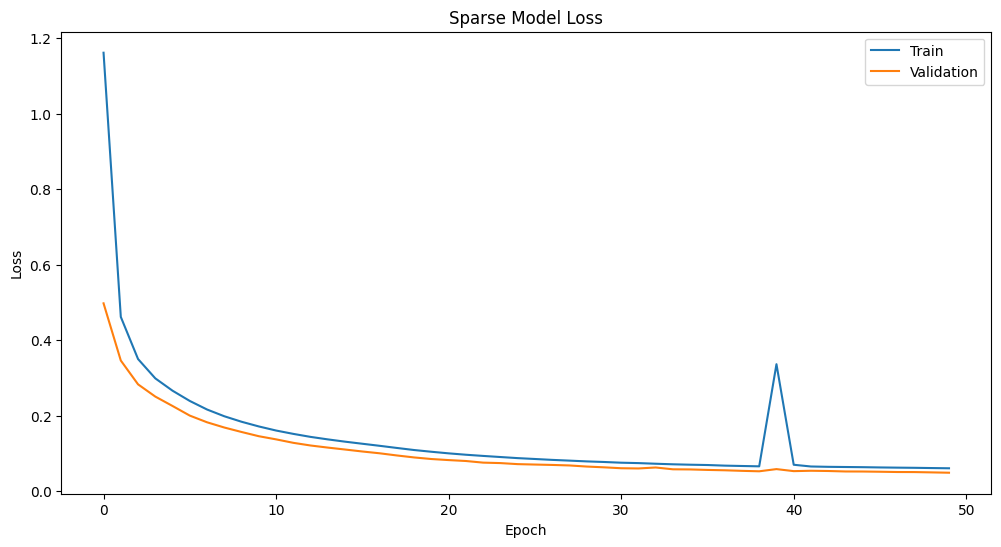

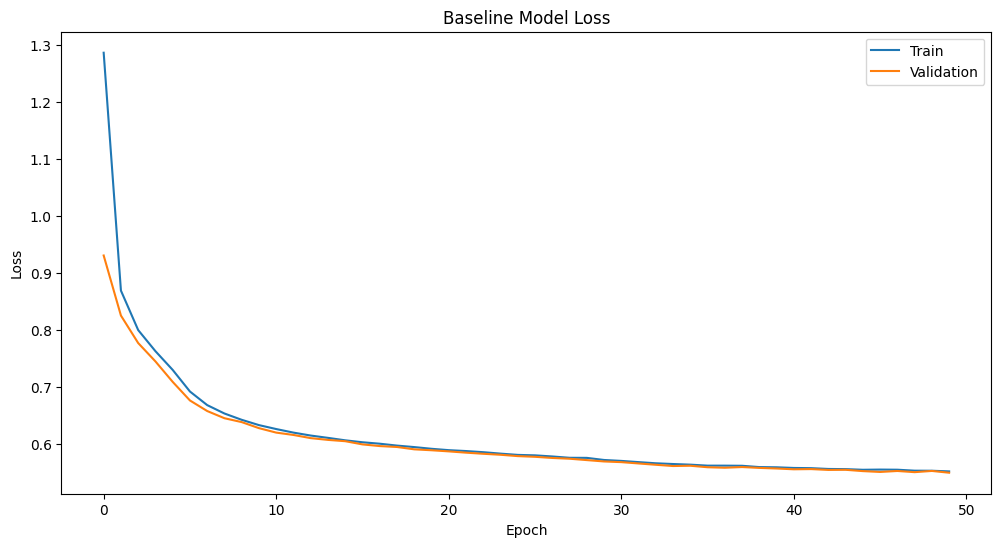

In [25]:
def plot_model_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_model_loss(train_losses_sparse, val_losses_sparse, 'Sparse')
plot_model_loss(train_losses_baseline, val_losses_baseline, 'Baseline')

Overall Performance

In [26]:
def evaluate_model(model, dataloader):
    total_loss = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()
    return total_loss / len(dataloader)

sparse_test_loss = evaluate_model(sparse_autoencoder, testloader)
baseline_test_loss = evaluate_model(baseline_autoencoder, testloader)

print(f"Sparse Autoencoder Test Loss: {sparse_test_loss:.4f}")
print(f"Baseline Autoencoder Test Loss: {baseline_test_loss:.4f}")

Sparse Autoencoder Test Loss: 0.0490
Baseline Autoencoder Test Loss: 0.5511


# Analysis

In [27]:
def denormalize(tensor, mean = (0.4914, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010)):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


Reconstruction Quality

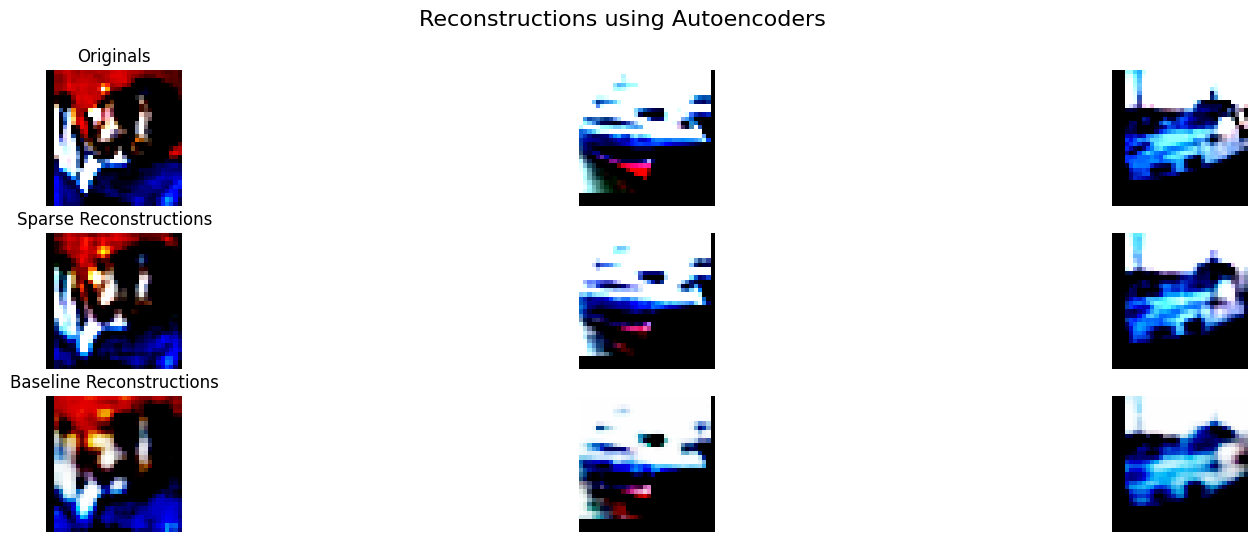

In [28]:
def display_reconstructions(model, baseline_model, dataloader, model_name, num_samples=3):
    with torch.no_grad():
        dataiter = iter(dataloader)
        original_images, _ = next(dataiter)
        sparse_reconstructed_images = model(original_images[:num_samples].cuda()).cpu()
        baseline_reconstructed_images = baseline_model(original_images[:num_samples].cuda()).cpu()

    fig, axes = plt.subplots(nrows=3, ncols=num_samples, figsize=(20, 6))

    for images, row, title in zip([original_images, sparse_reconstructed_images, baseline_reconstructed_images], axes, ["Originals", "Sparse Reconstructions", "Baseline Reconstructions"]):
        for img, ax in zip(images, row):
            img_clipped = torch.clamp(img, 0, 1)
            ax.imshow(img_clipped.permute(1, 2, 0).cpu().numpy())
            ax.axis('off')
        row[0].set_title(title)

    plt.suptitle(f"Reconstructions using {model_name}", fontsize=16)
    plt.subplots_adjust(wspace=0.1)

    plt.show()

display_reconstructions(sparse_autoencoder, baseline_autoencoder, testloader, "Autoencoders")


In [29]:
def evaluate_reconstruction_quality(model, dataloader):
    with torch.no_grad():
        dataiter = iter(dataloader)
        original_images, _ = next(dataiter)
        reconstructed_images = model(original_images.cuda()).cpu()
        reconstructed_images = denormalize(reconstructed_images)

    psnrs = []
    ssims = []

    for orig, recon in zip(original_images, reconstructed_images):
        orig_np = torch.clamp(orig, 0, 1).permute(1, 2, 0).numpy()
        recon_np = torch.clamp(recon, 0, 1).permute(1, 2, 0).numpy()

        psnr = compare_psnr(orig_np, recon_np, data_range=1)
        ssim, _ = compare_ssim(orig_np, recon_np, channel_axis=-1, full=True)

        psnrs.append(psnr)
        ssims.append(ssim)

    average_psnr = np.mean(psnrs)
    average_ssim = np.mean(ssims)

    return average_psnr, average_ssim


sparse_psnr, sparse_ssim = evaluate_reconstruction_quality(sparse_autoencoder, testloader)
baseline_psnr, baseline_ssim = evaluate_reconstruction_quality(baseline_autoencoder, testloader)

print(f"Sparse Autoencoder Reconstruction Quality: PSNR is {sparse_psnr:.4f}, SSIM is {sparse_ssim:.4f} ")
print(f"Baseline Autoencoder Reconstruction Quality: PSNR is {baseline_psnr:.4f}, SSIM is {baseline_ssim:.4f} ")

Sparse Autoencoder Reconstruction Quality: PSNR is 19.9217, SSIM is 0.8561 
Baseline Autoencoder Reconstruction Quality: PSNR is 17.8727, SSIM is 0.7964 



Visualize Filters

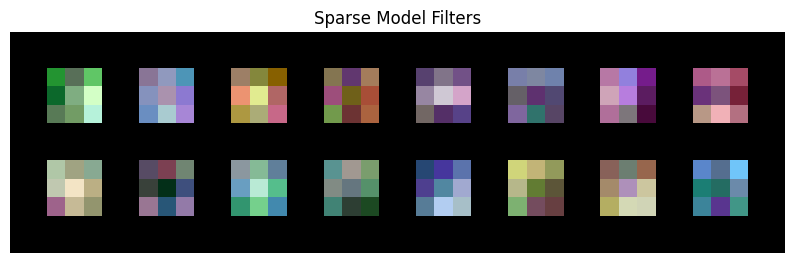

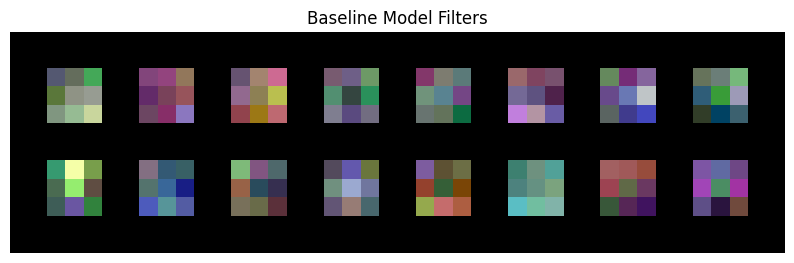

In [30]:
def visualize_filters(layer_weights, model_name):
    grid = make_grid(layer_weights, nrow=8, normalize=True)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"{model_name} Model Filters")
    plt.axis('off')
    plt.show()

visualize_filters(sparse_autoencoder.encoder[0].weight.data, "Sparse")
visualize_filters(baseline_autoencoder.encoder[0].weight.data, "Baseline")

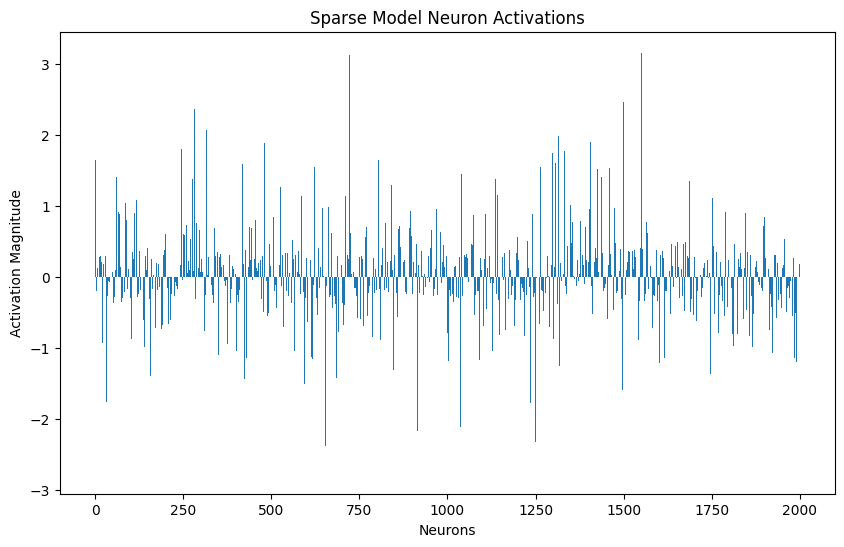

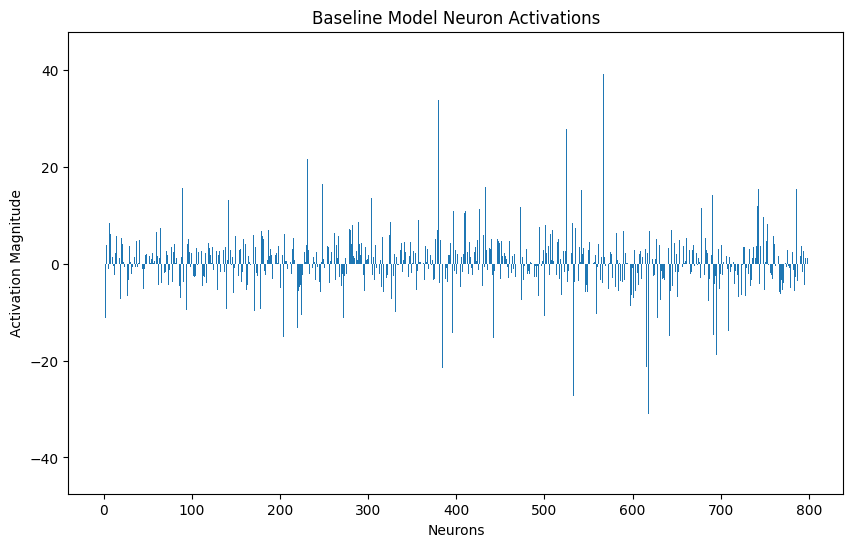

In [31]:
def visualize_activations(model, dataloader, model_name):
    dataiter = iter(dataloader)
    images, labels = dataiter.__next__()

    single_image = images[0].unsqueeze(0)
    if torch.cuda.is_available():
        single_image = single_image.cuda()

    single_label = labels[0]

    activations = model.extract_features(single_image)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(activations[0])), activations[0].cpu().detach().numpy())
    plt.title(f"{model_name} Model Neuron Activations")
    plt.xlabel("Neurons")
    plt.ylabel("Activation Magnitude")
    plt.show()

visualize_activations(sparse_autoencoder, testloader, "Sparse")
visualize_activations(baseline_autoencoder, testloader, "Baseline")

Computational Efficency

In [32]:
def compute_efficiency(model, dataloader):
    start_time = time.time()

    # Use our previously defined evaluate_model function
    loss = evaluate_model(model, dataloader)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return loss, elapsed_time

sparse_loss, sparse_time = compute_efficiency(sparse_autoencoder, testloader)
baseline_loss, baseline_time = compute_efficiency(baseline_autoencoder, testloader)

print(f"Sparse Autoencoder Inference Time: {sparse_time:.4f} seconds")
print(f"Baseline Autoencoder Inference Time: {baseline_time:.4f} seconds")

Sparse Autoencoder Inference Time: 3.6858 seconds
Baseline Autoencoder Inference Time: 5.4853 seconds


Robustness

In [33]:
def add_noise(data, noise_factor=0.5):
    noise = torch.randn_like(data) * noise_factor
    noisy_data = data + noise
    return noisy_data.clamp(0., 1.)

In [34]:
def evaluate_noisy_reconstruction(model, dataloader, noise_factor=0.5):
    device = next(model.parameters()).device  # Gets the device of the model
    total_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            noisy_data = add_noise(data, noise_factor)
            outputs = model(noisy_data)
            loss = criterion(outputs, data)
            total_loss += loss.item()

    return total_loss / len(dataloader)


sparse_noisy_loss = evaluate_noisy_reconstruction(sparse_autoencoder, testloader)
baseline_noisy_loss = evaluate_noisy_reconstruction(baseline_autoencoder, testloader)

print(f"Sparse Autoencoder Noisy Input Loss: {sparse_noisy_loss:.4f}")
print(f"Baseline Autoencoder Noisy Input Loss: {baseline_noisy_loss:.4f}")

Sparse Autoencoder Noisy Input Loss: 1.5412
Baseline Autoencoder Noisy Input Loss: 1.6027


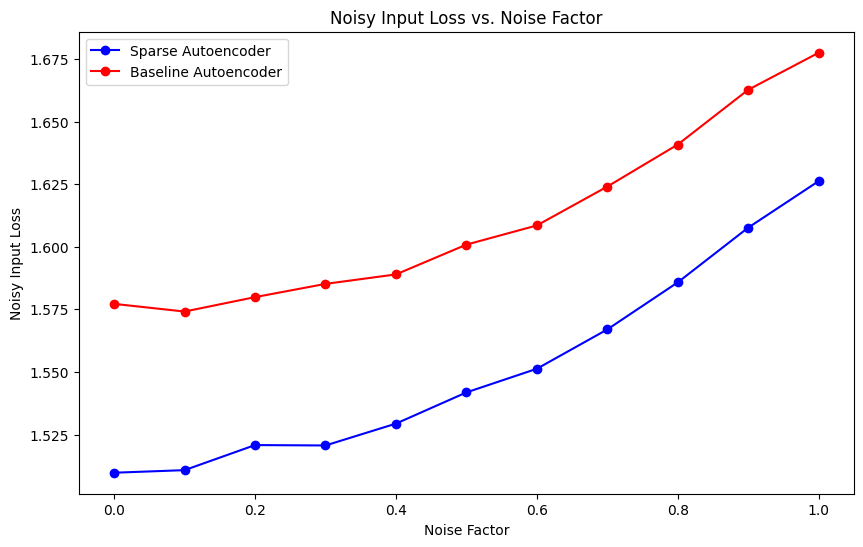

In [35]:
noise_factors = [i * 0.1 for i in range(11)]

sparse_losses = []
baseline_losses = []

for noise_factor in noise_factors:
    sparse_loss = evaluate_noisy_reconstruction(sparse_autoencoder, testloader, noise_factor)
    baseline_loss = evaluate_noisy_reconstruction(baseline_autoencoder, testloader, noise_factor)

    sparse_losses.append(sparse_loss)
    baseline_losses.append(baseline_loss)

plt.figure(figsize=(10, 6))
plt.plot(noise_factors, sparse_losses, label='Sparse Autoencoder', marker='o', color='blue')
plt.plot(noise_factors, baseline_losses, label='Baseline Autoencoder', marker='o', color='red')

plt.title('Noisy Input Loss vs. Noise Factor')
plt.xlabel('Noise Factor')
plt.ylabel('Noisy Input Loss')
plt.legend()
plt.show()


In [36]:
def extract_and_flatten_features(model, dataloader):
    features = []
    labels = []
    for data, target in dataloader:
        feature = model.extract_features(data.cuda()).cpu().detach().numpy()
        features.append(feature)
        labels.append(target.numpy())
    return np.vstack(features), np.concatenate(labels)

In [37]:
sparse_features, labels = extract_and_flatten_features(sparse_autoencoder, trainloader)
baseline_features, _ = extract_and_flatten_features(baseline_autoencoder, trainloader)

scaler_sparse = StandardScaler()
sparse_features_scaled = scaler_sparse.fit_transform(sparse_features)

scaler_baseline = StandardScaler()
baseline_features_scaled = scaler_baseline.fit_transform(baseline_features)

clf_sparse = LogisticRegression(max_iter=1000, solver='saga').fit(sparse_features_scaled, labels)
clf_baseline = LogisticRegression(max_iter=1000, solver='saga').fit(baseline_features_scaled, labels)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [38]:
def evaluate_classification(model, classifier, dataloader, noise_factor=0.5):
    features, true_labels = extract_and_flatten_features(model, dataloader)
    noisy_features = add_noise(torch.Tensor(features)).numpy()  # assuming the same noise factor
    predicted_labels = classifier.predict(noisy_features)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

sparse_accuracy = evaluate_classification(sparse_autoencoder, clf_sparse, testloader)
baseline_accuracy = evaluate_classification(baseline_autoencoder, clf_baseline, testloader)

print(f"Sparse Autoencoder Classification Accuracy on Noisy Data: {sparse_accuracy:.4f}")
print(f"Baseline Autoencoder Classification Accuracy on Noisy Data: {baseline_accuracy:.4f}")


Sparse Autoencoder Classification Accuracy on Noisy Data: 0.1374
Baseline Autoencoder Classification Accuracy on Noisy Data: 0.1065
